## Project 2: Advanced Lane Finding

### Camera calibration


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import copy

# Parameters
nx = 9 # number of corners inside chessboard in horizontal direction
ny = 6 # number of corners inside chessboard in vertical direction
calib_dir = "camera_cal/*" # directory of calibration images

# Initialize objpoints and imgpoints
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points like (0,0,0), (1,0,0), ..., (nx-1,ny-1,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
calib_imgs = glob.glob(calib_dir)

for fname in calib_imgs:
    # Read image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Finde the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

# Calculate camera matrix and distortion coeffients using objpoints and imgpoints
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

print("Camera matrix: ",mtx)
print("Distortion coefficient: ",dist)     

Camera matrix:  [[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion coefficient:  [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]


Compare before and after undistortion.

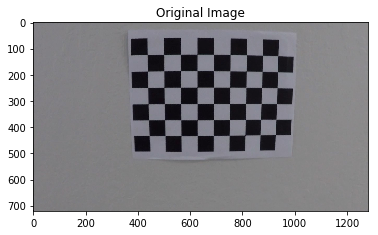

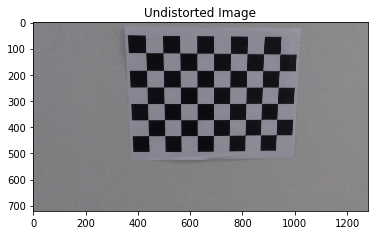

In [2]:
calib_orig = mpimg.imread(calib_imgs[3])

plt.imshow(calib_orig)
plt.title("Original Image")
plt.show()

calib_undist = cv2.undistort(calib_orig, mtx, dist, None, mtx)

plt.imshow(calib_undist)
plt.title("Undistorted Image")
plt.show()

### Apply distortion correction to an image

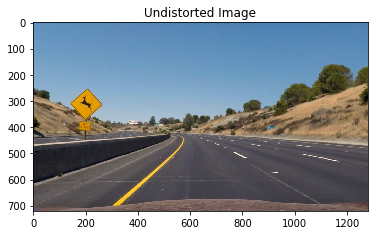

In [3]:
# Parameters
test_dir = "test_images/*" # directory of test images for pipeline on single frames

# Make a list of test images
test_imgs = glob.glob(test_dir)
fname = test_imgs[4]

img = mpimg.imread(fname)

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

plt.imshow(undist)
plt.title("Undistorted Image")
plt.show()

### Create thresholded binary image

In [4]:
def apply_threshold(img, show=False):
    # S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # Plotting thresholded images
    if show==True:
        plt.imshow(color_binary)
        plt.title("Channel Contributions (green: x grad, blue: s channel)")
        plt.show()
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

Apply threshold tothe undistorted image.

Use show=True option to visualize contributions of each channel.

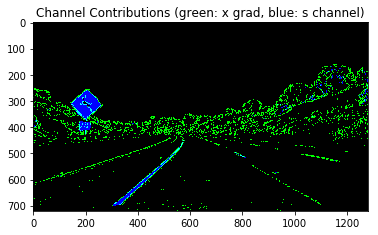

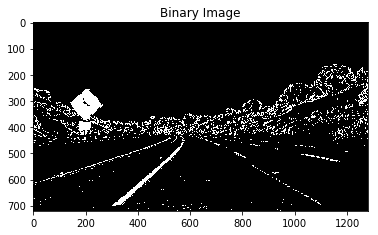

In [5]:
binary = apply_threshold(undist, show=True)

plt.imshow(binary, cmap='gray')
plt.title("Binary Image")
plt.show()

### Apply perspective transform

In [6]:
# Get perspective params from where we want straight lane lines to appear
# in the transformed image
def get_perspective_params(img):
    # Perspective transform parameters
    lane_width_y_65 = 0.12# lane width / image width ratio at 65% from top
    lane_width_y_100 = 0.72 # lane width / image width ratio at 100% from top

    x1 = img.shape[1]*(0.5-lane_width_y_100/2)
    x2 = img.shape[1]*(0.5-lane_width_y_65/2)
    x3 = img.shape[1]*(0.5+lane_width_y_65/2)
    x4 = img.shape[1]*(0.5+lane_width_y_100/2)
    y1 = img.shape[0]
    y2 = img.shape[0]*0.65
    src = np.array([[x1,y1],[x2,y2],[x3,y2],[x4,y1]], np.int32)

    x1 = img.shape[1]*0.2
    x2 = img.shape[1]*0.8
    y1 = img.shape[0]
    y2 = img.shape[0]*0.3

    dst = np.array([[x1,y1],[x1,y2],[x2,y2],[x2,y1]], np.int32)
    
    M = cv2.getPerspectiveTransform(np.float32(src),np.float32(dst))
    Minv = cv2.getPerspectiveTransform(np.float32(dst),np.float32(src))
    return M,Minv,src,dst

def check_perspective_params(img,src,dst):
    img_size = (img.shape[1],img.shape[0])
    perspective_lines = copy.copy(img)
    cv2.polylines(perspective_lines,[src],True,(0,0,255), thickness=3)
    plt.imshow(perspective_lines)
    plt.show()
    
    warped = cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(warped)
    plt.show()

def apply_perspective_transform(img,M):
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)
    return warped

Here, I check that parameters src, dst are defined properly.

Lane lines should appear nearly parallel in the transformed image.

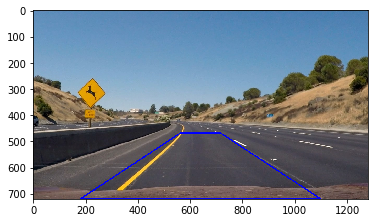

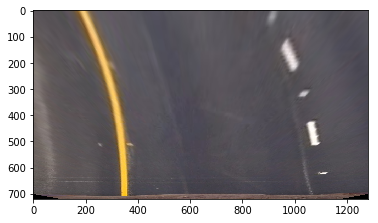

In [7]:
M,Minv,src,dst = get_perspective_params(img)
check_perspective_params(img,src,dst)

Apply perspective transform to binary image.

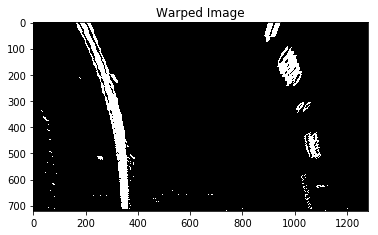

In [8]:
warped = apply_perspective_transform(binary,M)

plt.imshow(warped, cmap='gray')
plt.title("Warped Image")
plt.show()

### Detect Lane Pixels

In [9]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

def find_lane_pixels(binary_warped, debug=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if debug:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        #print("good left inds",((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        #(nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero())
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window
        #(`right` or `leftx_current`) on their mean position
        if len(good_left_inds)>minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, debug=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, debug=debug)

    #Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Plots the left and right polynomials on the lane lines
    if debug:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    else:
        xs = np.linspace(0, binary_warped.shape[1]-1, binary_warped.shape[1] )
        for x in range(binary_warped.shape[1]):
            for y in range(binary_warped.shape[0]):
                if (x>left_fitx[y])&(x<right_fitx[y]):
                    out_img[y,x] = [0,100,0]
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return left_fit,right_fit,out_img

Apply lane detection to warped binary image.

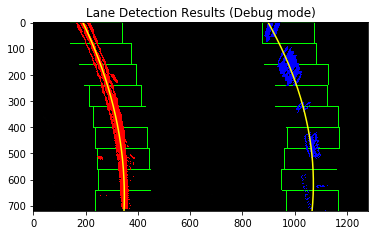

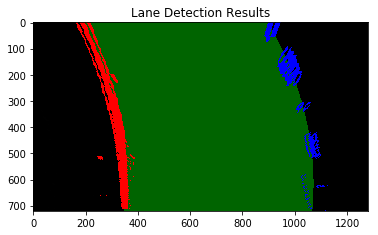

In [10]:
left_fit,right_fit,out_img = fit_polynomial(warped, debug=True)
plt.imshow(out_img)
plt.title("Lane Detection Results (Debug mode)")
plt.show()

left_fit,right_fit,out_img = fit_polynomial(warped, debug=False)
plt.imshow(out_img)
plt.title("Lane Detection Results")
plt.show()

In [11]:
def calculate_vehicle_position(left_fit,right_fit,out_img):
    xm_per_pix = 3.7/760 # meters per pixel in x dimension
    
    y_eval = out_img.shape[0]
    x_len = out_img.shape[1]
    # calculate left and right lane position
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    # calculate mid-lane position
    mid_x = (left_x+right_x)*0.5
    vehicle_position = -1*(mid_x - x_len/2)*xm_per_pix
    return vehicle_position
    
vehicle_position=calculate_vehicle_position(left_fit,right_fit,out_img)
if vehicle_position<0:
    print("Position is {:.2f} meters left of center".format(np.abs(vehicle_position)))
else:
    print("Position is {:.2f} meters right of center".format(vehicle_position))

Position is 0.32 meters left of center


### Find lane curvature

In [12]:
def measure_curvature_real(left_fit,right_fit,y_eval):
    '''
    Calculates the curvature of polynomial functions in meters.
    y_eval define y-value where we want radius of curvature
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/380 # meters per pixel in y dimension
    xm_per_pix = 3.7/760 # meters per pixel in x dimension
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    a = left_fit[0]
    b = left_fit[1]
    left_curverad = ((1+(2*a*y_eval*ym_per_pix+b)**2)**1.5)/(2*np.abs(a))
    a = right_fit[0]
    b = right_fit[1]
    right_curverad = ((1+(2*a*y_eval*ym_per_pix+b)**2)**1.5)/(2*np.abs(a))
    
    # compute curvature
    curvature = (left_curverad+right_curverad)*0.5 
    return curvature,left_curverad, right_curverad

Measure left and right lane curvature from polynomial.

Left curvature: 1798.57540653 m
Right curvature: 1549.93001869 m


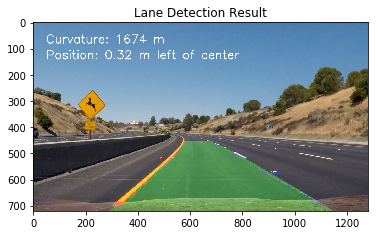

In [13]:
curvature,left_curverad, right_curverad = measure_curvature_real(left_fit,right_fit,720)
print("Left curvature:",left_curverad,'m')
print("Right curvature:",right_curverad,'m')
# compute lane curvature
#curvature = (left_curverad+right_curverad)*0.5 

# transform lane lines into original perspective
lanes = apply_perspective_transform(out_img,Minv)

# draw lane lines
combo=cv2.addWeighted(lanes,0.7,img,1,0)

# draw curvature text
txt = "Curvature: {:.0f} m".format(curvature)
combo = cv2.putText(combo, txt, (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)

# draw vehicle position text
vehicle_position=calculate_vehicle_position(left_fit,right_fit,out_img)
if vehicle_position<0:
    txt = "Position: {:.2f} m left of center".format(np.abs(vehicle_position))
else:
    txt = "Position: {:.2f} m right of center".format(np.abs(vehicle_position))
combo = cv2.putText(combo, txt, (50,140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)


plt.imshow(combo)
plt.title("Lane Detection Result")
plt.show()

### Lane Detection in a Video

In [14]:
def video_pipeline(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = apply_threshold(undist)
    warped = apply_perspective_transform(binary,M)
    left_fit,right_fit,out_img = fit_polynomial(warped)
    curvature,left_curverad, right_curverad = measure_curvature_real(left_fit,right_fit,720)
    
    # transform lane lines into original perspective
    lanes = apply_perspective_transform(out_img,Minv)
    
    # draw lane lines
    combo=cv2.addWeighted(lanes,0.7,img,1,0)
    
    # draw curvature text
    txt = "Curvature: {:.2f} m".format(curvature)
    combo = cv2.putText(combo, txt, (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)

    # draw vehicle position text
    vehicle_position=calculate_vehicle_position(left_fit,right_fit,out_img)
    if vehicle_position<0:
        txt = "Position: {:.2f} m left of center".format(np.abs(vehicle_position))
    else:
        txt = "Position: {:.2f} m right of center".format(np.abs(vehicle_position))
    combo = cv2.putText(combo, txt, (50,140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)

    return combo

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_video = "project_video.mp4"
output_video = "output_images/output_project_video.mp4"

#clip = VideoFileClip(input_video).subclip(0,5)
clip = VideoFileClip(input_video)

Input clip

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(input_video))

In [36]:
out_clip = clip.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_images/output_project_video.mp4
[MoviePy] Writing video output_images/output_project_video.mp4


100%|█████████▉| 1260/1261 [28:23<00:01,  1.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output_project_video.mp4 

CPU times: user 25min 56s, sys: 1.76 s, total: 25min 58s
Wall time: 28min 26s


Output clip

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))